In [2]:
import os
import dotenv

import boto3
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
from matplotlib import pyplot as plt

import pickle
import shutil

import locale

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import locale

locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

def formatar_moeda(valor):
    return locale.currency(valor, grouping=True)

In [5]:
tbl_debitos_dam_3 = r'C:\Users\Consultor\Documents\bases_pesquisa\verificacao\tbl_dam_debito_3.csv'
debitos_divida = pd.read_csv(tbl_debitos_dam_3)
debitos_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2021-01-26,1.0,38.0,2944.10,0.0,2944.10
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2019-01-08,1.0,38.0,2627.70,0.0,2627.70
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2022-01-21,1.0,38.0,3335.10,0.0,3335.10
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2023-01-23,1.0,38.0,3630.40,0.0,3630.40
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2017-01-26,1.0,38.0,2459.37,0.0,2459.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016992,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2022-11-09,0.0,41.0,626.75,0.0,628.62
2016993,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2021-11-08,0.0,41.0,568.39,0.0,570.09
2016994,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2017-11-10,0.0,41.0,503.20,0.0,503.20
2016995,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2018-11-09,0.0,41.0,515.10,0.0,515.10


In [6]:
def categorizar_porte(row):
    tipo_propriedade = row['tipo_propriedade']
    area_construida = row['area_construida']

    if tipo_propriedade == 'APARTAMENTO':
        if area_construida <= 60:
            return 'PEQUENO'
        elif 60 < area_construida <= 100:
            return 'MEDIO'
        else:
            return 'GRANDE'

    elif tipo_propriedade == 'CASA':
        if area_construida <= 100:
            return 'PEQUENO'
        elif 100 < area_construida <= 200:
            return 'MEDIO'
        else:
            return 'GRANDE'

    elif tipo_propriedade == 'LOJA':
        if area_construida <= 50:
            return 'PEQUENO'
        elif 50 < area_construida <= 200:
            return 'MEDIO'
        else:
            return 'GRANDE'

    elif tipo_propriedade == 'GARAGEM COMERCIAL':
        if area_construida <= 500:
            return 'PEQUENO'
        elif 500 < area_construida <= 2000:
            return 'MEDIO'
        else:
            return 'GRANDE'

    elif tipo_propriedade == 'GALPÃO':
        if 200 < area_construida <= 500:
            return 'PEQUENO'
        elif 500 < area_construida <= 2000:
            return 'MEDIO'
        else:
            return 'GRANDE'

    elif tipo_propriedade == 'SALA':
        if 20 <= area_construida <= 50:
            return 'PEQUENO'
        elif 50 < area_construida <= 150:
            return 'MEDIO'
        else:
            return 'GRANDE'

    else:
        return 'INDEFINIDO'
debitos_divida['tamanho_imovel'] = debitos_divida.apply(categorizar_porte, axis=1)
debitos_divida


,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2021-01-26,1.0,38.0,2944.10,0.0,2944.10,GRANDE
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2019-01-08,1.0,38.0,2627.70,0.0,2627.70,GRANDE
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2022-01-21,1.0,38.0,3335.10,0.0,3335.10,GRANDE
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2023-01-23,1.0,38.0,3630.40,0.0,3630.40,GRANDE
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2017-01-26,1.0,38.0,2459.37,0.0,2459.37,GRANDE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016992,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2022-11-09,0.0,41.0,626.75,0.0,628.62,MEDIO
2016993,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2021-11-08,0.0,41.0,568.39,0.0,570.09,MEDIO
2016994,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2017-11-10,0.0,41.0,503.20,0.0,503.20,MEDIO
2016995,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2018-11-09,0.0,41.0,515.10,0.0,515.10,MEDIO


In [7]:
arq_bairros = r'C:\Users\Consultor\Documents\bases_pesquisa\bairro\bairro.xlsx'
tbl_bairros = pd.read_excel(arq_bairros)
tbl_bairros 

,bairro,regiao,rpa
0,AFLITOS,NORDESTE,3A
1,AFOGADOS,SUDESTE,5
2,AGUA FRIA,NORTE,2
3,ALTO JOSE BONIFACIO,NORDESTE,3B
4,ALTO JOSE DO PINHO,NORDESTE,3B
...,...,...,...
89,TORROES,OESTE,4
90,TOTO,SUDESTE,5
91,VARZEA,OESTE,4
92,VASCO DA GAMA,NORDESTE,3B


In [8]:
arq_natureza = r'C:\Users\Consultor\Documents\bases_pesquisa\verificacao\RELACAO_IMOVEL_TIPO_CONTRIBUINTE.xlsx'
tbl_pf_pj = pd.read_excel(arq_natureza)
tbl_pf_pj 

,id_imovel,tipo_contribuinte
0,6b3a8e268c80aedf,PF
1,200d024ed1d1cc90,PJ
2,730b78533133f903,PJ
3,408002743410a58c,PJ
4,b7e964d611a3baa8,PF
...,...,...
517851,42e13a28e98c6be0,PF
517852,4b1a9413a179e1ea,PF
517853,6e3c9674c93ba1eb,PF
517854,b9e1dd322b5fbe3e,PF


In [9]:
debitos_divida = pd.merge(debitos_divida, tbl_pf_pj, on='id_imovel', how='left')
debitos_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,tipo_contribuinte
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2021-01-26,1.0,38.0,2944.10,0.0,2944.10,GRANDE,PF
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2019-01-08,1.0,38.0,2627.70,0.0,2627.70,GRANDE,PF
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2022-01-21,1.0,38.0,3335.10,0.0,3335.10,GRANDE,PF
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2023-01-23,1.0,38.0,3630.40,0.0,3630.40,GRANDE,PF
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2017-01-26,1.0,38.0,2459.37,0.0,2459.37,GRANDE,PF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016992,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2022-11-09,0.0,41.0,626.75,0.0,628.62,MEDIO,PF
2016993,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2021-11-08,0.0,41.0,568.39,0.0,570.09,MEDIO,PF
2016994,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2017-11-10,0.0,41.0,503.20,0.0,503.20,MEDIO,PF
2016995,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2018-11-09,0.0,41.0,515.10,0.0,515.10,MEDIO,PF


In [10]:
debitos_divida = pd.merge(debitos_divida, tbl_bairros, on='bairro', how='left')
debitos_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,tipo_contribuinte,regiao,rpa
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2021-01-26,1.0,38.0,2944.10,0.0,2944.10,GRANDE,PF,NORDESTE,3A
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2019-01-08,1.0,38.0,2627.70,0.0,2627.70,GRANDE,PF,NORDESTE,3A
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2022-01-21,1.0,38.0,3335.10,0.0,3335.10,GRANDE,PF,NORDESTE,3A
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-01-23,1.0,38.0,3630.40,0.0,3630.40,GRANDE,PF,NORDESTE,3A
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2017-01-26,1.0,38.0,2459.37,0.0,2459.37,GRANDE,PF,NORDESTE,3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016992,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2022-11-09,0.0,41.0,626.75,0.0,628.62,MEDIO,PF,OESTE,4
2016993,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2021-11-08,0.0,41.0,568.39,0.0,570.09,MEDIO,PF,OESTE,4
2016994,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2017-11-10,0.0,41.0,503.20,0.0,503.20,MEDIO,PF,OESTE,4
2016995,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2018-11-09,0.0,41.0,515.10,0.0,515.10,MEDIO,PF,OESTE,4


In [11]:
debitos_divida['percentual_pago'] = debitos_divida['vlr_pago'] / (debitos_divida['vlr_aberto'] + debitos_divida['vlr_pago']) * 100
debitos_divida['vlr_devido'] = debitos_divida['vlr_aberto'] + debitos_divida['vlr_pago']

In [21]:
debitos_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,tipo_contribuinte,regiao,rpa,percentual_pago,vlr_devido
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,38.0,2944.10,0.0,2944.10,GRANDE,PF,NORDESTE,3A,100.0,2944.10
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,38.0,2627.70,0.0,2627.70,GRANDE,PF,NORDESTE,3A,100.0,2627.70
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,38.0,3335.10,0.0,3335.10,GRANDE,PF,NORDESTE,3A,100.0,3335.10
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,38.0,3630.40,0.0,3630.40,GRANDE,PF,NORDESTE,3A,100.0,3630.40
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,38.0,2459.37,0.0,2459.37,GRANDE,PF,NORDESTE,3A,100.0,2459.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016992,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,41.0,626.75,0.0,628.62,MEDIO,PF,OESTE,4,100.0,626.75
2016993,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,41.0,568.39,0.0,570.09,MEDIO,PF,OESTE,4,100.0,568.39
2016994,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,41.0,503.20,0.0,503.20,MEDIO,PF,OESTE,4,100.0,503.20
2016995,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,41.0,515.10,0.0,515.10,MEDIO,PF,OESTE,4,100.0,515.10


In [62]:
formatar_moeda(debitos_divida['vlr_aberto'].sum())

'R$ 834.888.260,11'

In [13]:
idade_imo_20_a_50_anos = debitos_divida.query('idade_imovel > 20 & idade_imovel <= 50')
# idade_imo_20_anos

In [63]:
corrigido_idcontribuinte_faltante = analisar_dataframe(debitos_divida)

In [69]:
idade_imo_ate_20 = debitos_divida.query('idade_imovel <= 20')
idade_imo_20_a_50_anos = debitos_divida.query('idade_imovel > 20 & idade_imovel <= 50')
idade_imo_maior_que_50_anos = debitos_divida.query('idade_imovel > 50')

In [60]:
analise_22 = idade_imo_ate_20.groupby(['ano_fato_gerador']).agg({
    'vlr_aberto': 'sum',
    'vlr_pago': 'sum',
    'vlr_devido': 'sum'
}).reset_index()
analise_22

,ano_fato_gerador,vlr_aberto,vlr_pago,vlr_devido
0,2017.0,12900820.26,2.056156e+08,2.185164e+08
1,2018.0,18057076.24,2.079355e+08,2.259925e+08
2,2019.0,13915917.34,2.645521e+08,2.784680e+08
3,2020.0,18649379.12,2.731914e+08,2.918408e+08
4,2021.0,11267166.37,2.891398e+08,3.004069e+08
5,2022.0,60414665.52,3.313388e+08,3.917534e+08
6,2023.0,73927054.34,3.427475e+08,4.166745e+08


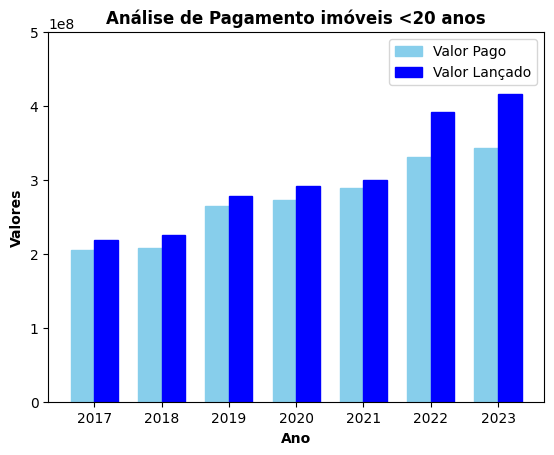

In [61]:
analise_corte = pd.DataFrame(analise_22)

analise_corte['ano_fato_gerador'] = analise_corte['ano_fato_gerador'].astype(int).astype(str)

anos = analise_corte['ano_fato_gerador']
valores_pagos = analise_corte['vlr_pago']
valores_total = analise_corte['vlr_devido']

barWidth = 0.35 

r1 = np.arange(len(anos))
r2 = [x + barWidth for x in r1]

plt.bar(r1, valores_pagos, color='skyblue', width=barWidth, edgecolor='skyblue', label='Valor Pago')
plt.bar(r2, valores_total, color='blue', width=barWidth, edgecolor='blue', label='Valor Lançado')


plt.xlabel('Ano', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(anos))], anos)
plt.ylabel('Valores', fontweight='bold')
plt.title('Análise de Pagamento imóveis <20 anos', fontweight='bold')
plt.legend()

plt.ylim(0, 500000000)
# plt.yticks([0, 50000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000])
plt.show()

In [623]:
idade_imo_maior_que_50_anos['vlr_pago'].sum() / ((idade_imo_maior_que_50_anos['vlr_pago'].sum()) + (idade_imo_maior_que_50_anos['vlr_aberto'].sum())) * 100

80.45496561564146

In [64]:
# formatar_moeda(idade_imo_ate_20['vlr_aberto'].sum())
# formatar_moeda(idade_imo_20_a_50_anos['vlr_aberto'].sum())
formatar_moeda(idade_imo_maior_que_50_anos['vlr_aberto'].sum())

'R$ 200.844.762,15'

In [67]:
varzea = idade_imo_20_a_50_anos[idade_imo_20_a_50_anos['bairro'].str.strip() == 'VARZEA']
varzea

,id_imovel,id_contribuinte,vlr_aberto,vlr_pago,idade_imovel,tamanho_imovel,natureza_imovel,bairro,tipo_propriedade,tipo_contribuinte
16,0003694f49bc4a7c,0fd94a3fa05a3ff71603ecd7ff6be21f,0.00,4244.70,41.0,MEDIO,P,VARZEA,APARTAMENTO,PF
272,00315152c4d28296,783beac0f0b2770eacc7ff10b872fdd2,0.00,5899.91,50.0,MEDIO,P,VARZEA,CASA,PF
294,003441c759f77a41,e089acf0b5a94b7b98653cfb631c3e04,2734.81,0.00,30.0,MEDIO,P,VARZEA,APARTAMENTO,PJ
317,0039d32ba041921e,3461375338df2efc0246e2b93c1bf25c,1535.30,0.00,40.0,INDEFINIDO,T,VARZEA,None,PF
386,0044cb5a5df4c078,f0ab1b21beefd982b52d42c6eb89d24d,0.00,13880.60,40.0,INDEFINIDO,T,VARZEA,None,PJ
...,...,...,...,...,...,...,...,...,...,...
348112,ffd8b5f10d9ac760,bbdfcae77d9aff560246e2b93c1bf25c,0.00,6589.51,37.0,GRANDE,P,VARZEA,APARTAMENTO,PF
348113,ffd8d60c6992c05f,3a17bbdf48d4366cccef8250158c4d35,0.00,4092.42,24.0,PEQUENO,P,VARZEA,CASA,PF
348191,ffe817ac9709938b,b523dc08aab5eb28acc7ff10b872fdd2,8942.50,6844.85,22.0,INDEFINIDO,P,VARZEA,EDIFICAÇÃO ESPECIAL,PF
348201,ffeb2900f67c1292,e089acf0b5a94b7b98653cfb631c3e04,0.00,2049.22,30.0,MEDIO,P,VARZEA,APARTAMENTO,PJ


In [327]:
formatar_moeda(testin['vlr_aberto'].sum())

'R$ 4.883.031,28'

In [19]:
def analisar_dataframe(df):
    analise = df.groupby(['id_imovel', 'id_contribuinte']).agg({
        'vlr_aberto': 'sum',
        'vlr_pago': 'sum',
        'idade_imovel': 'first',
        'tamanho_imovel': 'first',
        'natureza_imovel': 'first',
        'bairro': 'first',
        'tipo_propriedade': 'first',
        'tipo_contribuinte': 'first'
    }).reset_index()
    
    return analise

In [20]:
def calcular_contagens(df_anterior, df_atual):
    imoveis_unicos_anterior = set(df_anterior['id_imovel'])
    imoveis_unicos_atual = set(df_atual['id_imovel'])

    imoveis_novos = imoveis_unicos_atual - imoveis_unicos_anterior
    quantidade_imoveis_novos = len(imoveis_novos)

    return quantidade_imoveis_novos

In [68]:
varzea_17 = varzea[varzea['ano_fato_gerador'] == 2017]
varzea_18 = varzea[varzea['ano_fato_gerador'] == 2018]
varzea_19 = varzea[varzea['ano_fato_gerador'] == 2019]
varzea_20 = varzea[varzea['ano_fato_gerador'] == 2020]
varzea_21 = varzea[varzea['ano_fato_gerador'] == 2021]
varzea_22 = varzea[varzea['ano_fato_gerador'] == 2022]
varzea_23 = varzea[varzea['ano_fato_gerador'] == 2023]

KeyError: 'ano_fato_gerador'

In [575]:
varzea_analise_17 = analisar_dataframe(varzea_17)
varzea_analise_18 = analisar_dataframe(varzea_18)
varzea_analise_19 = analisar_dataframe(varzea_19)
varzea_analise_20 = analisar_dataframe(varzea_20)
varzea_analise_21 = analisar_dataframe(varzea_21)
varzea_analise_22 = analisar_dataframe(varzea_22)
varzea_analise_23 = analisar_dataframe(varzea_23)
print(f"Quantidade de imóveis únicos em 2017: {varzea_analise_17['id_imovel'].nunique()}")
print(f"Quantidade de imóveis únicos em 2018: {varzea_analise_18['id_imovel'].nunique()}")
print(f"Quantidade de imóveis únicos em 2019: {varzea_analise_19['id_imovel'].nunique()}")
print(f"Quantidade de imóveis únicos em 2020: {varzea_analise_20['id_imovel'].nunique()}")
print(f"Quantidade de imóveis únicos em 2021: {varzea_analise_21['id_imovel'].nunique()}")
print(f"Quantidade de imóveis únicos em 2022: {varzea_analise_22['id_imovel'].nunique()}")
print(f"Quantidade de imóveis únicos em 2023: {varzea_analise_23['id_imovel'].nunique()}")

Quantidade de imóveis únicos em 2017: 5625
Quantidade de imóveis únicos em 2018: 5108
Quantidade de imóveis únicos em 2019: 5622
Quantidade de imóveis únicos em 2020: 5544
Quantidade de imóveis únicos em 2021: 5397
Quantidade de imóveis únicos em 2022: 9256
Quantidade de imóveis únicos em 2023: 9263


In [576]:
imoveis_por_ano = {
    'Ano': [2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'Total_imoveis': [5625, 5108, 5622, 5544, 5397, 9256, 9263]
}
df_imoveis_total = pd.DataFrame(imoveis_por_ano)
df_imoveis_total

,Ano,Total_imoveis
0,2017,5625
1,2018,5108
2,2019,5622
3,2020,5544
4,2021,5397
5,2022,9256
6,2023,9263


In [65]:
varzea_novos_imoveis_18 = calcular_contagens(varzea_analise_17, varzea_analise_18)
varzea_novos_imoveis_19 = calcular_contagens(varzea_analise_18, varzea_analise_19)
varzea_novos_imoveis_20 = calcular_contagens(varzea_analise_19, varzea_analise_20)
varzea_novos_imoveis_21 = calcular_contagens(varzea_analise_20, varzea_analise_21)
varzea_novos_imoveis_22 = calcular_contagens(varzea_analise_21, varzea_analise_22)
varzea_novos_imoveis_23 = calcular_contagens(varzea_analise_22, varzea_analise_23)
print(f"Quantidade de imóveis únicos em 2018: {varzea_novos_imoveis_18}")
print(f"Quantidade de imóveis únicos em 2019: {varzea_novos_imoveis_19}")
print(f"Quantidade de imóveis únicos em 2020: {varzea_novos_imoveis_20}")
print(f"Quantidade de imóveis únicos em 2021: {varzea_novos_imoveis_21}")
print(f"Quantidade de imóveis únicos em 2022: {varzea_novos_imoveis_22}")
print(f"Quantidade de imóveis únicos em 2023: {varzea_novos_imoveis_23}")

NameError: name 'varzea_analise_17' is not defined

In [434]:
nao_pagam = ibura_22.query('vlr_pago == 0')
pagam_parcialmente = ibura_21.query('(vlr_aberto != 0) & (vlr_aberto < vlr_pago)')
pagam = ibura_21.query('vlr_aberto == 0')

In [ ]:
pagam

In [433]:
formatar_moeda(pagam['vlr_pago'].sum())

'R$ 2.523.231,19'

In [578]:
imoveis_nv = {
    'Ano': [2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'Novos_Imoveis': [0, 449, 896, 348, 286, 3891, 27]
}
df_imoveis_novos = pd.DataFrame(imoveis_nv)
df_imoveis_novos

,Ano,Novos_Imoveis
0,2017,0
1,2018,449
2,2019,896
3,2020,348
4,2021,286
5,2022,3891
6,2023,27


In [579]:
evolucao_imoveis = pd.merge(df_imoveis_total, df_imoveis_novos, on='Ano', how='left')
evolucao_imoveis

,Ano,Total_imoveis,Novos_Imoveis
0,2017,5625,0
1,2018,5108,449
2,2019,5622,896
3,2020,5544,348
4,2021,5397,286
5,2022,9256,3891
6,2023,9263,27


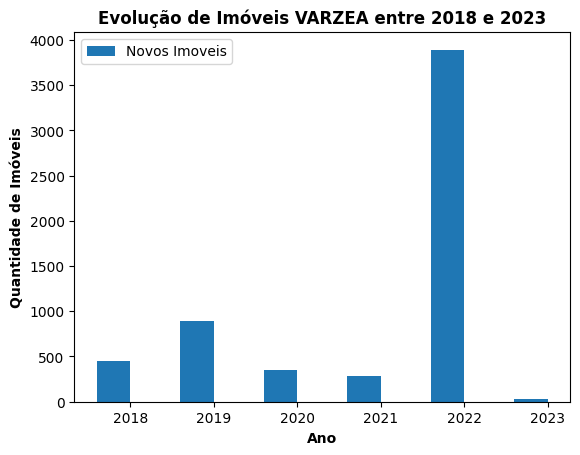

In [477]:
grafico = pd.DataFrame(evolucao_imoveis)
grafico = grafico[grafico['Ano'] != 2017]

plt.bar(grafico['Ano'] - 0.2, grafico['Novos_Imoveis'], width=0.4, label='Novos Imoveis', align='center')

plt.xlabel('Ano', fontweight='bold')
plt.ylabel('Quantidade de Imóveis', fontweight='bold')
plt.title('Evolução de Imóveis VARZEA entre 2018 e 2023', fontweight='bold')
plt.legend()
plt.show()

In [262]:
df_anterior = ibura_analise_21
df_atual = ibura_analise_22
imoveis_unicos_anterior = set(df_anterior['id_imovel'])
imoveis_unicos_atual = set(df_atual['id_imovel'])

imoveis_novos = imoveis_unicos_atual - imoveis_unicos_anterior
df_imoveis_novos = pd.DataFrame({'id_imovel_novo': list(imoveis_novos)})
df_imoveis_novos
# quantidade_imoveis_novos = len(imoveis_novos)
# quantidade_imoveis_novos

# print(f"Quantidade de imóveis únicos em 2022 que não estavam presentes em 2021: {quantidade_imoveis_novos}")

,id_imovel_novo
0,772afe5f36465cfd
1,a6f0e9f3c3e14c8b
2,aa2e48e407970fb0
3,5080fbbd997039c5
4,b32923a2129f2b31
...,...
93413,4a0fb61307837e84
93414,64aa4692766dbd4f
93415,da3c3b588e5ef166
93416,9ea4d3a5ab4fb763


In [445]:
formatar_moeda(ibura_analise_22['vlr_aberto'].sum())

'R$ 7.377.728,14'

In [516]:
df_anterior = varzea_analise_21
df_atual = varzea_analise_22
imoveis_unicos_anterior = set(df_anterior['id_imovel'])
imoveis_unicos_atual = set(df_atual['id_imovel'])

imoveis_novos = imoveis_unicos_atual - imoveis_unicos_anterior

df_novos_anterior = df_anterior[df_anterior['id_imovel'].isin(imoveis_novos)]
df_novos_atual = df_atual[df_atual['id_imovel'].isin(imoveis_novos)]

colunas_desejadas = ['id_imovel', 'tipo_propriedade', 'vlr_aberto', 'vlr_pago', 'bairro', 'tamanho_imovel']
df_novos_anterior = df_novos_anterior[colunas_desejadas]
df_novos_atual = df_novos_atual[colunas_desejadas]

df_final = pd.merge(df_novos_anterior, df_novos_atual, on='id_imovel', how='outer')
df_final

,tipo_propriedade_x,vlr_aberto_x,vlr_pago_x,bairro_x,tamanho_imovel_x,id_imovel,tipo_propriedade_y,vlr_aberto_y,vlr_pago_y,bairro_y,tamanho_imovel_y
0,NaN,NaN,NaN,NaN,NaN,003441c759f77a41,APARTAMENTO,1449.29,0.00,VARZEA,MEDIO
1,NaN,NaN,NaN,NaN,NaN,0039d32ba041921e,None,811.85,0.00,VARZEA,INDEFINIDO
2,NaN,NaN,NaN,NaN,NaN,005eb8ece530a713,CASA,1730.99,0.00,VARZEA,MEDIO
3,NaN,NaN,NaN,NaN,NaN,007244eb356c2c07,APARTAMENTO,584.14,0.00,VARZEA,MEDIO
4,NaN,NaN,NaN,NaN,NaN,00a1d9c72407c5ef,None,961.74,0.00,VARZEA,INDEFINIDO
...,...,...,...,...,...,...,...,...,...,...,...
3886,NaN,NaN,NaN,NaN,NaN,ff8285aa13449104,CASA,547.00,0.00,VARZEA,PEQUENO
3887,NaN,NaN,NaN,NaN,NaN,ff8c6f4b1bb1af1b,APARTAMENTO,1449.29,0.00,VARZEA,MEDIO
3888,NaN,NaN,NaN,NaN,NaN,ffa607a825010a10,None,1187.67,0.00,VARZEA,INDEFINIDO
3889,NaN,NaN,NaN,NaN,NaN,ffcf0471c0b1baf3,CASA,0.00,720.12,VARZEA,PEQUENO


In [586]:
df_final['tipo_propriedade_y'].replace('None', np.nan, inplace=True)
df_final.loc[df_final['tipo_propriedade_y'].isnull(), 'tamanho_imovel_y'] = 'TERRENO'
df_final['tipo_propriedade_y'] = df_final['tipo_propriedade_y'].str.strip()
df_final['tipo_propriedade_y'].replace('INDEFINIDO', 'OUTROS', inplace=True)
df_final

,tipo_propriedade_x,vlr_aberto_x,vlr_pago_x,bairro_x,tamanho_imovel_x,id_imovel,tipo_propriedade_y,vlr_aberto_y,vlr_pago_y,bairro_y,tamanho_imovel_y
0,NaN,NaN,NaN,NaN,NaN,003441c759f77a41,APARTAMENTO,1449.29,0.00,VARZEA,MEDIO
1,NaN,NaN,NaN,NaN,NaN,0039d32ba041921e,None,811.85,0.00,VARZEA,TERRENO
2,NaN,NaN,NaN,NaN,NaN,005eb8ece530a713,CASA,1730.99,0.00,VARZEA,MEDIO
3,NaN,NaN,NaN,NaN,NaN,007244eb356c2c07,APARTAMENTO,584.14,0.00,VARZEA,MEDIO
4,NaN,NaN,NaN,NaN,NaN,00a1d9c72407c5ef,None,961.74,0.00,VARZEA,TERRENO
...,...,...,...,...,...,...,...,...,...,...,...
3886,NaN,NaN,NaN,NaN,NaN,ff8285aa13449104,CASA,547.00,0.00,VARZEA,PEQUENO
3887,NaN,NaN,NaN,NaN,NaN,ff8c6f4b1bb1af1b,APARTAMENTO,1449.29,0.00,VARZEA,MEDIO
3888,NaN,NaN,NaN,NaN,NaN,ffa607a825010a10,None,1187.67,0.00,VARZEA,TERRENO
3889,NaN,NaN,NaN,NaN,NaN,ffcf0471c0b1baf3,CASA,0.00,720.12,VARZEA,PEQUENO


In [ ]:
pequeno = df_final.query('tamanho_imovel_y == "PEQUENO"')
medio = df_final.query('tamanho_imovel_y == "MEDIO"')
grande = df_final.query('tamanho_imovel_y == "GRANDE"')
terreno = df_final.query('tamanho_imovel_y == "TERRENO"')
outros = df_final.query('tamanho_imovel_y == "INDEFINIDO"')
outros

In [513]:
formatar_moeda(grande['vlr_aberto_y'].sum())

'R$ 1.220.448,78'

In [386]:
contagem_por_bairro = df_final.groupby('bairro_y')['id_imovel'].nunique().reset_index()
contagem_por_bairro = contagem_por_bairro.sort_values(by='id_imovel', ascending=False)
contagem_por_bairro.head(20)

,bairro_y,id_imovel
12,BOA VIAGEM,5697
91,VARZEA,3891
49,IMBIRIBEIRA,2396
31,CORDEIRO,2304
45,IBURA,2234
8,AREIAS,1816
1,AFOGADOS,1755
51,IPUTINGA,1694
29,COHAB,1395
53,JARDIM SAO PAULO,1363


In [323]:
formatar_moeda(df_final['vlr_aberto_y'].sum())

'R$ 3.820.585,44'

In [590]:
tipo_propri = df_final.groupby(['tipo_propriedade_y']).agg({
    'vlr_aberto_y': 'sum',
    'vlr_pago_y': 'sum',
    'id_imovel': 'count'
}).reset_index()
tipo_propri

,tipo_propriedade_y,vlr_aberto_y,vlr_pago_y,id_imovel
0,APARTAMENTO,1332523.73,251174.05,1715
1,CASA,1558721.61,261423.16,873
2,GALPÃO,310809.83,14723.67,43
3,GARAGEM COMERCIAL,997.24,0.00,1
4,HOTEL,59416.76,0.00,2
5,INDUSTRIA,137784.00,2946.30,3
6,INSTITUIÇÃO FINANCEIRA,65296.39,0.00,1
7,LOJA,208880.18,34876.22,103
8,MOCAMBO,1785.36,54.29,7
9,OUTROS,1030659.14,134897.19,18


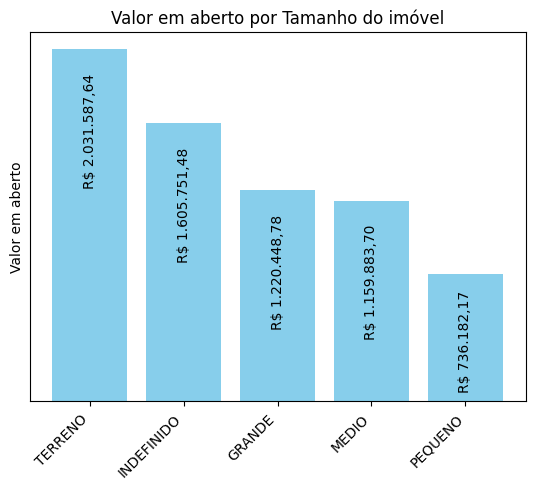

In [589]:
filtrando = tipo_propri.head(10)

fig, ax = plt.subplots()
filtrando = filtrando.sort_values(by='id_imovel', ascending=False)

bars = ax.bar(filtrando['tipo_propriedade_y'], filtrando['vlr_aberto_y'], color='Skyblue')

ax.set_ylabel('Valor em aberto')
ax.set_title('Valor em aberto por tipo propriedade')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_yticks([])
for i, bar in enumerate(bars):
    yval = bar.get_height()
    
    if i < 4:
        xytext_config = (0, -100) 
    elif 4 <= i < 7:
        xytext_config = (0, -85) 
    else:
        xytext_config = (0, -20)
    
    ax.annotate(formatar_moeda(yval),
                xy=(bar.get_x() + bar.get_width() / 2, yval),
                xytext=xytext_config,
                textcoords="offset points",
                ha='center', va='bottom', rotation=90)

plt.show()

In [592]:
valores_nulos = df_final['tipo_propriedade_y'].isnull().sum()
print(f'Imóveis caracterizados como terreno em tipo_propriedade: {valores_nulos}')

contagem_labels = df_final['tipo_propriedade_y'].value_counts()
frame = contagem_labels.to_frame().reset_index()
frame['percentual'] = frame['count'] / frame['count'].sum() * 100
frame

Imóveis caracterizados como terreno em tipo_propriedade: 1116


,tipo_propriedade_y,count,percentual
0,APARTAMENTO,1715,61.801802
1,CASA,873,31.459459
2,LOJA,103,3.711712
3,GALPÃO,43,1.549550
4,OUTROS,18,0.648649
5,SALA,9,0.324324
6,MOCAMBO,7,0.252252
7,INDUSTRIA,3,0.108108
8,HOTEL,2,0.072072
9,INSTITUIÇÃO FINANCEIRA,1,0.036036


In [506]:
tamanho = {
    'Tamanho_imovel': ['PEQUENO', 'TERRENO', 'MEDIO', 'GRANDE'],
    'Percentual_imovel': [33.384734, 28.68157, 26.214341, 9.817528]
}
df_tamanho = pd.DataFrame(tamanho)
df_tamanho

,Tamanho_imovel,Percentual_imovel
0,PEQUENO,33.384734
1,TERRENO,28.681570
2,MEDIO,26.214341
3,GRANDE,9.817528


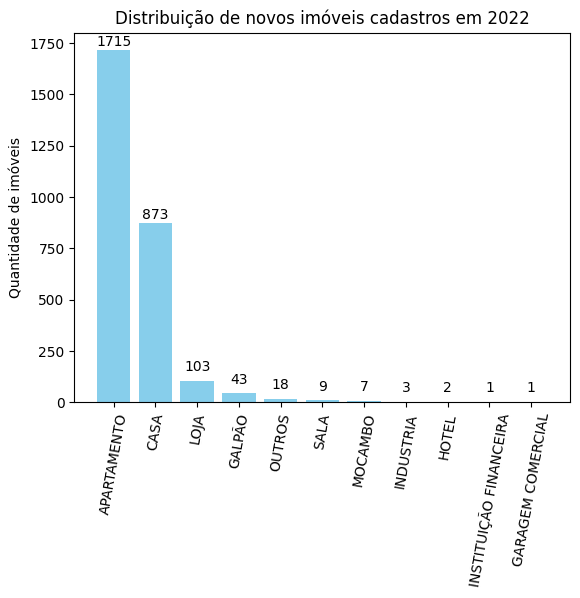

In [609]:
filtrando = frame

fig, ax = plt.subplots()
# filtrando = filtrando.sort_values(by='count', ascending=False)

bars = ax.bar(filtrando['tipo_propriedade_y'], filtrando['count'], color='Skyblue')

ax.set_ylabel('Quantidade de imóveis')
ax.set_title('Distribuição de novos imóveis cadastros em 2022')

ax.set_xticklabels(ax.get_xticklabels(), rotation=80, ha='center')

#ax.set_yticks([])
for i, bar in enumerate(bars):
    percentual = filtrando.iloc[i]['count']
    yval = bar.get_height()
    
    if i < 2:
        xytext_config = (0, 1) 
    elif 2 <= i < 3:
        xytext_config = (0, 5) 
    else:
        xytext_config = (0, 5)
    
    ax.annotate(percentual,
                xy=(bar.get_x() + bar.get_width() / 2, yval),
                xytext=xytext_config,
                textcoords="offset points",
                ha='center', va='bottom', rotation=0)

plt.show()

In [276]:
def formatar_percentual(numero):
    numero_formatado = round(numero, 2)
    percentual_formatado = "{:.2f}%".format(numero_formatado)
    return percentual_formatado

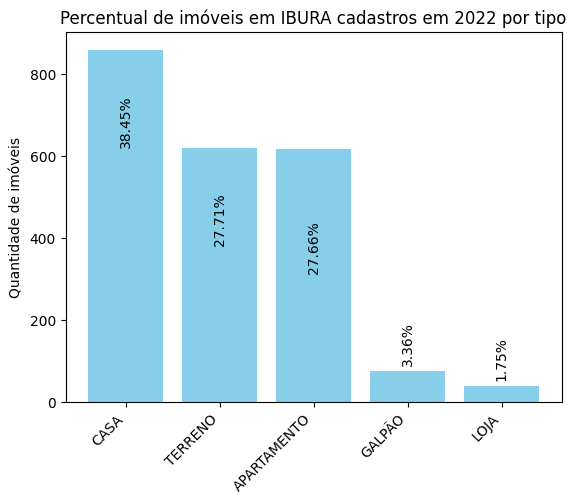

In [315]:
filtrando = frame.head(5)

fig, ax = plt.subplots()
filtrando = filtrando.sort_values(by='count', ascending=False)

bars = ax.bar(filtrando['tipo_propriedade_y'], filtrando['count'], color='Skyblue')

ax.set_ylabel('Quantidade de imóveis')
ax.set_title('Percentual de imóveis em IBURA cadastros em 2022 por tipo')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

#ax.set_yticks([])
for i, bar in enumerate(bars):
    percentual = filtrando.iloc[i]['percentual']
    yval = bar.get_height()
    
    if i < 2:
        xytext_config = (0, -70) 
    elif 2 <= i < 3:
        xytext_config = (0, -90) 
    else:
        xytext_config = (0, 4)
    
    ax.annotate(formatar_percentual(percentual),
                xy=(bar.get_x() + bar.get_width() / 2, yval),
                xytext=xytext_config,
                textcoords="offset points",
                ha='center', va='bottom', rotation=90)

plt.show()

In [229]:
analise_geral = debitos_divida.groupby(['id_imovel','id_contribuinte']).agg({
    'vlr_aberto': 'sum',
    'vlr_pago': 'sum',
    'idade_imovel': 'first',
    'tamanho_imovel': 'first',
    # 'ano_fato_gerador': 'first',
    'natureza_imovel': 'first',
    'bairro': 'first',
    'tipo_propriedade': 'first',
    'tipo_contribuinte': 'first'
}).reset_index()
analise_geral
analise_geral['percentual_pago'] = analise_geral['vlr_pago'] / (analise_geral['vlr_aberto'] + analise_geral['vlr_pago']) * 100
analise_geral['valor_devido'] = (analise_geral['vlr_aberto'] + analise_geral['vlr_pago'])


In [318]:
debitos_divida = pd.DataFrame(ibura)

df_2021 = debitos_divida[debitos_divida['ano_fato_gerador'] == 2021]
df_2022 = debitos_divida[debitos_divida['ano_fato_gerador'] == 2022]
imoveis_unicos_2021 = set(df_2021['id_imovel'])
imoveis_unicos_2022 = set(df_2022['id_imovel'])

imoveis_novos_2022 = imoveis_unicos_2022 - imoveis_unicos_2021
quantidade_imoveis_novos_2022 = len(imoveis_novos_2022)

print(f"Quantidade de imóveis únicos em 2022 que não estavam presentes em 2021: {quantidade_imoveis_novos_2022}")

Quantidade de imóveis únicos em 2022 que não estavam presentes em 2021: 3024


In [139]:
analise = pd.DataFrame(analise_22)

# Inicializar listas para armazenar contagem de imóveis únicos e novos imóveis
contagem_total = []
contagem_novos = []

# Inicializar conjunto vazio para rastrear id_imovel único global
imoveis_unicos_globais = set()

# Iterar sobre os anos e calcular as contagens
for ano in range(2018, 2024):
    # Filtrar DataFrame para o ano atual
    df_ano_atual = analise[analise['ano_fato_gerador'] == ano]
    
    # Contagem total de imóveis únicos no ano
    imoveis_unicos_ano_atual = set(df_ano_atual['id_imovel'])
    contagem_total.append(len(imoveis_unicos_ano_atual))
    
    # Contagem de novos imóveis que não apareceram no ano anterior
    imoveis_novos = imoveis_unicos_ano_atual - imoveis_unicos_globais
    contagem_novos.append(len(imoveis_novos))
    
    # Atualizar conjunto global de imóveis únicos
    imoveis_unicos_globais.update(imoveis_unicos_ano_atual)

# Criar DataFrame com as contagens
contagem_df = pd.DataFrame({'Ano': list(range(2018, 2024)),
                            'Total': contagem_total,
                            'Novos': contagem_novos})

# Exibir o DataFrame
contagem_df

,Ano,Total,Novos
0,2018,2261,2261
1,2019,2444,392
2,2020,2307,105
3,2021,2244,72
4,2022,4472,1678
5,2023,4476,4


In [163]:
oi = pd.DataFrame(analise_22)
imoveis_unicos_2022 = oi['id_imovel'].nunique()

print(f"Quantidade de imóveis únicos em 2022: {imoveis_unicos_2022}")


Quantidade de imóveis únicos em 2022: 4472


In [115]:
# Chunk para analisar imóveis que estão em um ano e não estão em outro
novos_imoveis = pd.DataFrame(ibura)

imoveis_2021 = novos_imoveis[novos_imoveis['ano_fato_gerador'] == 2021]['id_imovel'].unique()
imoveis_2022 = novos_imoveis[novos_imoveis['ano_fato_gerador'] == 2022]['id_imovel'].unique()

imoveis_nao_presentes_2021 = set(imoveis_2022) - set(imoveis_2021)
imoveis_nao_presentes_em_2021 = novos_imoveis[novos_imoveis['id_imovel'].isin(imoveis_nao_presentes_2021) & (novos_imoveis['ano_fato_gerador'] == 2022)].drop_duplicates(subset='id_imovel')
imoveis_nao_presentes_em_2021

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,tipo_contribuinte,regiao,rpa,percentual_pago
276,0008e8e909bb4f70,8d6aa25ea31dc00c875350beaddc7871,b1b8a6102d62c900179357218888e6f8,2022.0,1,NaN,1,T,NaN,NaN,...,0.0,30.0,0.0,995.55,995.55,INDEFINIDO,PJ,SUL,6B,0.0
1071,00213549e3da6359,ee66b82e24a25991875350beaddc7871,85ea454917d000799daa7b7dbb545c1c,2022.0,1,47.93,1,P,CASA,CONSTRUÍDA,...,0.0,24.0,0.0,357.48,357.48,PEQUENO,PF,SUL,6B,0.0
1139,002353de21033ffe,290992e808428653875350beaddc7871,NaN,2022.0,1,67.00,1,P,CASA,CONSTRUÍDA,...,0.0,23.0,0.0,672.86,672.86,PEQUENO,PF,SUL,6B,0.0
1301,0029d505cdee5309,9e8034034145f3c9875350beaddc7871,1ffe56671c69341b0246e2b93c1bf25c,2022.0,1,56.30,1,P,APARTAMENTO,CONSTRUÍDA,...,0.0,29.0,449.0,0.00,521.53,PEQUENO,PF,SUL,6B,100.0
1496,002fda9d8daf0861,cf82d8b4bbdebb08875350beaddc7871,dbfd0bc68a16f38db52d42c6eb89d24d,2022.0,1,NaN,1,T,NaN,NaN,...,0.0,40.0,0.0,789.46,789.46,INDEFINIDO,PJ,SUL,6B,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014358,ffad1ef07d3db126,a21fa2c690385311875350beaddc7871,NaN,2022.0,2,114.19,1,P,CASA,CONSTRUÍDA,...,0.0,24.0,0.0,896.30,896.30,MEDIO,PF,SUL,6B,0.0
2014850,ffbd4625122de737,bb0a8374755b79db875350beaddc7871,43a02617639cfbc4a79038f64d77cadf,2022.0,1,93.00,1,P,CASA,CONSTRUÍDA,...,0.0,41.0,0.0,980.64,980.64,PEQUENO,PJ,SUL,6B,0.0
2015548,ffd4e9767ff1bf97,3b5fd66ba33f011a875350beaddc7871,06745691d67d4ba7d8b209292c0ce31d,2022.0,2,268.00,1,P,GALPÃO,CONSTRUÍDA,...,0.0,36.0,0.0,7855.98,7855.98,INDEFINIDO,PF,SUL,6B,0.0
2015981,ffe24d0d5be696e7,838e936e9203accc875350beaddc7871,ee11260e64c800e31603ecd7ff6be21f,2022.0,1,312.00,0,P,EDIFICAÇÃO ESPECIAL,CONSTRUÍDA,...,0.0,33.0,0.0,10416.93,10416.93,INDEFINIDO,PF,SUL,6B,0.0


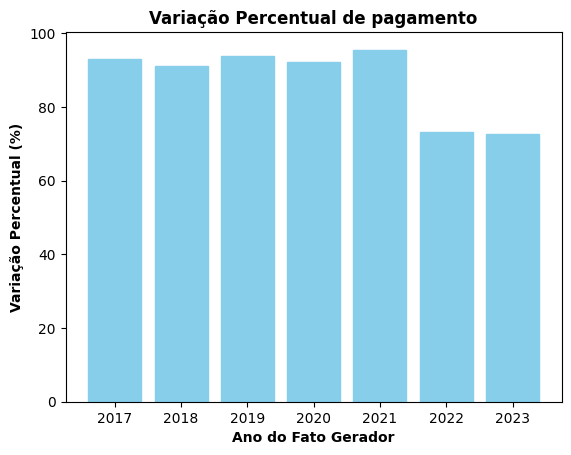

In [80]:
analise_22 = pd.DataFrame(analise_22)

# analise_22['var_percentual'] = (analise_22['percentual_pago'] - analise_22.loc[analise_22['ano_fato_gerador'] == 2017, 'percentual_pago'].iloc[0]) / analise_22.loc[analise_22['ano_fato_gerador'] == 2017, 'percentual_pago'].iloc[0] * 100

plt.bar(analise_22['ano_fato_gerador'], analise_22['percentual_pago'], color='skyblue', edgecolor='skyblue')

plt.xlabel('Ano do Fato Gerador', fontweight='bold')
plt.ylabel('Variação Percentual (%)', fontweight='bold')
plt.title('Variação Percentual de pagamento', fontweight='bold')
plt.show()

85% é a média de pagamento da base total

In [57]:
formatar_moeda(analise_22['vlr_aberto'].sum())
# formatar_moeda(analise_22['vlr_pago'].sum())

'R$ 827.743.486,30'

In [58]:
formatar_moeda(analise_22['vlr_pago'].sum())

'R$ 4.751.664.924,56'

In [60]:
4751664924.56 / 5579408410.86 * 100

85.16431446945444

In [ ]:
analise_22 = ibura.groupby(['ano_fato_gerador']).agg({
    'vlr_aberto': 'sum',
    'vlr_pago': 'sum'
}).reset_index()
analise_22

analise_22['percentual_pago'] = analise_22['vlr_pago'] / (analise_22['vlr_aberto'] + analise_22['vlr_pago']) * 100
analise_22['valor_devido'] = (analise_22['vlr_aberto'] + analise_22['vlr_pago'])

# analise_22['valor_devido'] = analise_22['valor_devido'].apply(formatar_moeda)
# analise_22['vlr_aberto'] = analise_22['vlr_aberto'].apply(formatar_moeda)
# analise_22['vlr_pago'] = analise_22['vlr_pago'].apply(formatar_moeda)
analise_22

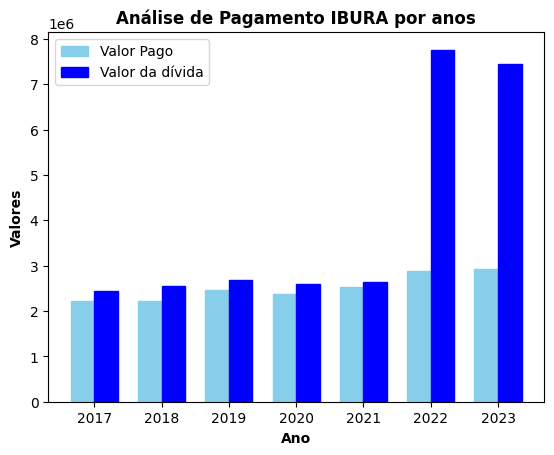

In [317]:
analise_22 = pd.DataFrame(analise_22)

analise_22['ano_fato_gerador'] = analise_22['ano_fato_gerador'].astype(int).astype(str)

anos = analise_22['ano_fato_gerador']
valores_pagos = analise_22['vlr_pago']
valores_total = analise_22['valor_devido']

barWidth = 0.35 

r1 = np.arange(len(anos))
r2 = [x + barWidth for x in r1]

plt.bar(r1, valores_pagos, color='skyblue', width=barWidth, edgecolor='skyblue', label='Valor Pago')
plt.bar(r2, valores_total, color='blue', width=barWidth, edgecolor='blue', label='Valor da dívida')

plt.xlabel('Ano', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(anos))], anos)
plt.ylabel('Valores', fontweight='bold')
plt.title('Análise de Pagamento IBURA por anos', fontweight='bold')
plt.legend()
plt.show()

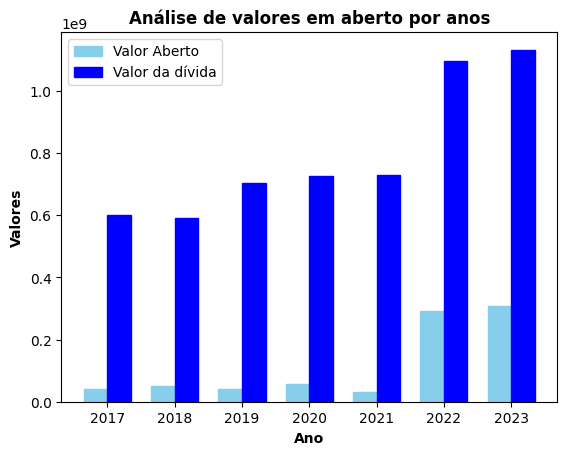

In [75]:
analise_22 = pd.DataFrame(analise_22)

analise_22['ano_fato_gerador'] = analise_22['ano_fato_gerador'].astype(int).astype(str)

anos = analise_22['ano_fato_gerador']
valores_pagos = analise_22['vlr_aberto']
valores_total = analise_22['valor_devido']

barWidth = 0.35 

r1 = np.arange(len(anos))
r2 = [x + barWidth for x in r1]

plt.bar(r1, valores_pagos, color='skyblue', width=barWidth, edgecolor='skyblue', label='Valor Aberto')
plt.bar(r2, valores_total, color='blue', width=barWidth, edgecolor='blue', label='Valor da dívida')

plt.xlabel('Ano', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(anos))], anos)
plt.ylabel('Valores', fontweight='bold')
plt.title('Análise de valores em aberto por anos', fontweight='bold')
plt.legend()
plt.show()

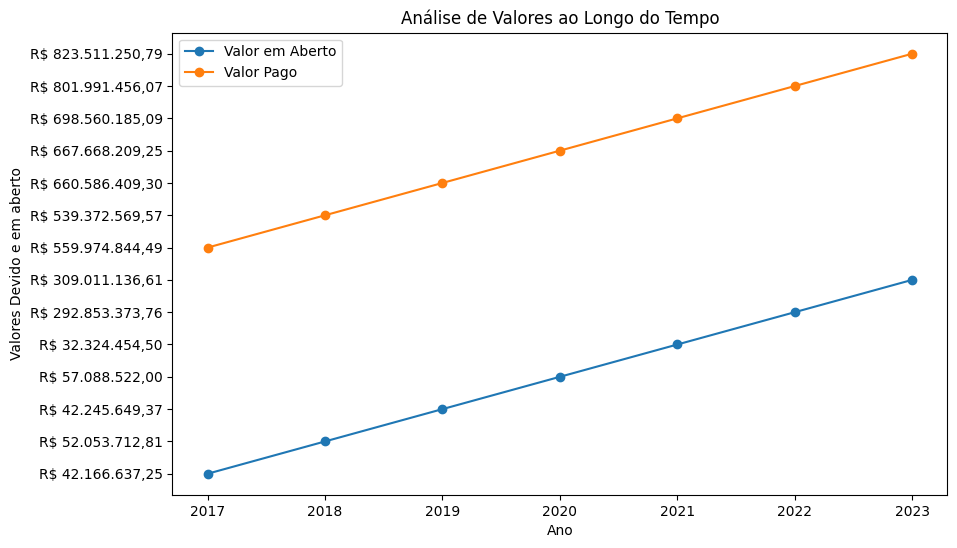

In [51]:
analise_22 = pd.DataFrame(analise_22)
plt.figure(figsize=(10, 6))

plt.plot(analise_22['ano_fato_gerador'], analise_22['vlr_aberto'], label='Valor em Aberto', marker='o')
plt.plot(analise_22['ano_fato_gerador'], analise_22['vlr_pago'], label='Valor Pago', marker='o')

plt.title('Análise de Valores ao Longo do Tempo')
plt.xlabel('Ano')
plt.ylabel('Valores Devido e em aberto')
plt.legend()

In [27]:
descricao = debitos_divida.groupby('idade_imovel')['vlr_aberto'].describe()
descricao

,count,mean,std,min,25%,50%,75%,max
idade_imovel,,,,,,,,
0.0,1550.0,2292.169800,7893.786582,0.00,0.0000,612.060,1105.3700,126780.28
1.0,585.0,250.681402,594.220043,0.00,0.0000,0.000,0.0000,5831.82
2.0,7227.0,335.436193,2942.143566,0.00,0.0000,0.000,0.0000,120340.37
3.0,8688.0,503.373529,6865.816374,0.00,0.0000,0.000,0.0000,315051.73
4.0,14645.0,364.091136,3380.174481,0.00,0.0000,0.000,0.0000,192421.82
...,...,...,...,...,...,...,...,...
106.0,11.0,211.536364,471.211122,0.00,0.0000,0.000,0.0000,1215.37
108.0,11.0,4462.028182,7650.788811,0.00,0.0000,0.000,7715.3750,16949.38
109.0,7.0,0.000000,0.000000,0.00,0.0000,0.000,0.0000,0.00


In [ ]:
analise_geral = debitos_divida.groupby(['id_imovel','id_contribuinte']).agg({
    'vlr_aberto': 'sum',
    'vlr_pago': 'sum',
    'idade_imovel': 'first',
    'tamanho_imovel': 'first',
    # 'ano_fato_gerador': 'first',
    'natureza_imovel': 'first',
    'bairro': 'first',
    'tipo_propriedade': 'first',
    'tipo_contribuinte': 'first'
}).reset_index()
analise_geral
analise_geral['percentual_pago'] = analise_geral['vlr_pago'] / (analise_geral['vlr_aberto'] + analise_geral['vlr_pago']) * 100
analise_geral['valor_devido'] = (analise_geral['vlr_aberto'] + analise_geral['vlr_pago'])

In [239]:
analise_idade = analise_geral.groupby(['idade_imovel']).agg({
    'vlr_aberto': 'sum',
    'vlr_pago': 'sum'
}).reset_index()
analise_idade
analise_idade['percentual_pago'] = analise_idade['vlr_pago'] / (analise_idade['vlr_aberto'] + analise_idade['vlr_pago']) * 100
analise_idade['valor_devido'] = (analise_idade['vlr_aberto'] + analise_idade['vlr_pago'])

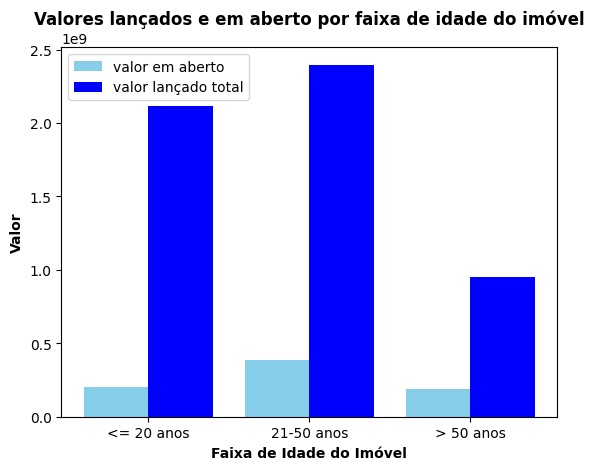

In [250]:
opa = pd.DataFrame(analise_geral)

grupos = opa.groupby(pd.cut(opa['idade_imovel'], bins=[0, 20, 50, float('inf')]))
soma_por_faixa = grupos[['vlr_aberto', 'valor_devido']].sum().reset_index()

plt.bar(soma_por_faixa.index - 0.2, soma_por_faixa['vlr_aberto'], width=0.4, label='valor em aberto', align='center', color='skyblue')
plt.bar(soma_por_faixa.index + 0.2, soma_por_faixa['valor_devido'], width=0.4, label='valor lançado total', align='center', color='blue')

# Adicionar rótulos e legendas
plt.xlabel('Faixa de Idade do Imóvel', fontweight='bold')
plt.ylabel('Valor', fontweight='bold')
plt.title('Valores lançados e em aberto por faixa de idade do imóvel', fontweight='bold')
plt.xticks(soma_por_faixa.index, ['<= 20 anos', '21-50 anos', '> 50 anos'])
plt.legend()
plt.show()

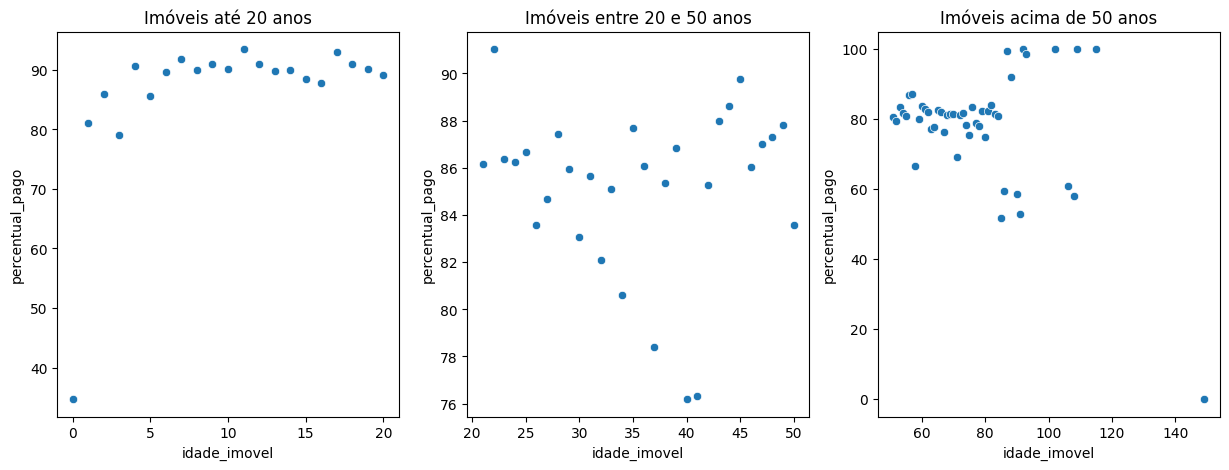

In [236]:
anali = pd.DataFrame(analise_idade)

# Dividir o DataFrame em faixas de idade
faixa_20 = anali[anali['idade_imovel'] <= 20]
faixa_20_50 = anali[(anali['idade_imovel'] > 20) & (anali['idade_imovel'] <= 50)]
faixa_50 = anali[anali['idade_imovel'] > 50]

# Criar gráficos de dispersão para cada faixa de idade
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(data=faixa_20, x='idade_imovel', y='percentual_pago')
plt.title('Imóveis até 20 anos')

plt.subplot(1, 3, 2)
sns.scatterplot(data=faixa_20_50, x='idade_imovel', y='percentual_pago')
plt.title('Imóveis entre 20 e 50 anos')

plt.subplot(1, 3, 3)
sns.scatterplot(data=faixa_50, x='idade_imovel', y='percentual_pago')
plt.title('Imóveis acima de 50 anos')

plt.show()

In [10]:
idade_imo_menor_50_anos = debitos_divida.query('idade_imovel > 20 & idade_imovel <= 50')
idade_imo_menor_50_anos

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,tipo_contribuinte,regiao,rpa
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2021-01-26,1.0,38.0,2944.10,0.0,2944.10,GRANDE,PF,NORDESTE,3A
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2019-01-08,1.0,38.0,2627.70,0.0,2627.70,GRANDE,PF,NORDESTE,3A
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2022-01-21,1.0,38.0,3335.10,0.0,3335.10,GRANDE,PF,NORDESTE,3A
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-01-23,1.0,38.0,3630.40,0.0,3630.40,GRANDE,PF,NORDESTE,3A
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2017-01-26,1.0,38.0,2459.37,0.0,2459.37,GRANDE,PF,NORDESTE,3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016992,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2022-11-09,0.0,41.0,626.75,0.0,628.62,MEDIO,PF,OESTE,4
2016993,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2021-11-08,0.0,41.0,568.39,0.0,570.09,MEDIO,PF,OESTE,4
2016994,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2017-11-10,0.0,41.0,503.20,0.0,503.20,MEDIO,PF,OESTE,4
2016995,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2018-11-09,0.0,41.0,515.10,0.0,515.10,MEDIO,PF,OESTE,4


# Contagem de IMÓVEIS por tipo de propriedade

In [11]:
tipo_propriedade = pd.DataFrame(idade_imo_menor_50_anos)
contagem_imoveis = tipo_propriedade.groupby(['tipo_propriedade', 'ano_fato_gerador'])['id_imovel'].nunique().reset_index()
resultado_imoveis = contagem_imoveis.pivot(index='tipo_propriedade', columns='ano_fato_gerador', values='id_imovel').fillna(0)
resultado_imoveis

ano_fato_gerador,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
tipo_propriedade,,,,,,,
APARTAMENTO,71596.0,66336.0,72218.0,71496.0,69502.0,87884.0,88376.0
CASA,37206.0,35114.0,36797.0,35098.0,33897.0,63624.0,63614.0
CENTRO COMERCIAL/SERVIÇOS,4.0,3.0,4.0,4.0,4.0,4.0,3.0
EDIFICAÇÃO ESPECIAL,880.0,824.0,894.0,843.0,837.0,1272.0,1277.0
GALPÃO,1283.0,1232.0,1305.0,1238.0,1227.0,2060.0,2080.0
GALPÃO FECHADO,20.0,20.0,19.0,18.0,18.0,22.0,22.0
GARAGEM COMERCIAL,916.0,839.0,951.0,909.0,888.0,1396.0,1396.0
GARAGEM RESIDENCIAL,9.0,1.0,1.0,0.0,0.0,0.0,0.0
HOSPITAL,45.0,34.0,41.0,42.0,34.0,49.0,52.0


# Valor em aberto por tipo de Propriedade 

In [12]:
# VALOR EM ABERTO
arruda = pd.DataFrame(idade_imo_menor_50_anos)
valor_aberto = arruda.pivot_table(index='tipo_propriedade', columns='ano_fato_gerador', values='vlr_aberto', aggfunc='sum', fill_value=0)
for coluna in valor_aberto.columns:
    valor_aberto[coluna] = valor_aberto[coluna].apply(formatar_moeda)
valor_aberto

ano_fato_gerador,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
tipo_propriedade,,,,,,,
APARTAMENTO,"R$ 7.291.808,82","R$ 8.897.234,74","R$ 7.460.450,73","R$ 9.541.661,32","R$ 5.392.548,45","R$ 40.066.868,15","R$ 46.182.472,98"
CASA,"R$ 5.033.102,87","R$ 5.968.803,52","R$ 4.627.651,80","R$ 5.848.444,60","R$ 3.132.510,02","R$ 55.593.760,66","R$ 52.710.149,85"
CENTRO COMERCIAL/SERVIÇOS,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00"
EDIFICAÇÃO ESPECIAL,"R$ 1.076.356,02","R$ 1.051.947,11","R$ 1.152.039,15","R$ 2.112.855,35","R$ 841.330,72","R$ 11.016.820,41","R$ 11.601.127,72"
GALPÃO,"R$ 1.275.215,79","R$ 1.654.971,37","R$ 1.248.270,65","R$ 1.515.857,22","R$ 843.505,92","R$ 8.597.243,95","R$ 8.740.426,62"
GALPÃO FECHADO,"R$ 8.850,85","R$ 15.828,67","R$ 0,00","R$ 4.488,49","R$ 0,00","R$ 171.463,34","R$ 131.589,81"
GARAGEM COMERCIAL,"R$ 64.836,42","R$ 2.688,00","R$ 11.695,10","R$ 14.180,36","R$ 12.724,93","R$ 319.488,62","R$ 312.915,91"
GARAGEM RESIDENCIAL,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00"
HOSPITAL,"R$ 77.642,97","R$ 50.559,76","R$ 173.533,57","R$ 45.851,47","R$ 36.490,98","R$ 450.139,50","R$ 1.398.201,54"


# analisando o ano em que houve queda na arrecadação e aumento da dívida

In [331]:
analise_2022 = idade_imo_menor_50_anos.query('ano_fato_gerador == 2022')

In [393]:
# Chunk para analisar imóveis que estão em um ano e não estão em outro
novos_imoveis = pd.DataFrame(ibura)

imoveis_2021 = novos_imoveis[novos_imoveis['ano_fato_gerador'] == 2021]['id_imovel'].unique()
imoveis_2022 = novos_imoveis[novos_imoveis['ano_fato_gerador'] == 2022]['id_imovel'].unique()

imoveis_nao_presentes_2021 = set(imoveis_2022) - set(imoveis_2021)
imoveis_nao_presentes_em_2021 = novos_imoveis[novos_imoveis['id_imovel'].isin(imoveis_nao_presentes_2021) & (novos_imoveis['ano_fato_gerador'] == 2022)].drop_duplicates(subset='id_imovel')
imoveis_nao_presentes_em_2021

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,tipo_contribuinte,regiao,rpa,percentual_pago
276,0008e8e909bb4f70,8d6aa25ea31dc00c875350beaddc7871,b1b8a6102d62c900179357218888e6f8,2022.0,1,NaN,1,T,NaN,NaN,...,0.0,30.0,0.0,995.55,995.55,INDEFINIDO,PJ,SUL,6B,0.0
1071,00213549e3da6359,ee66b82e24a25991875350beaddc7871,85ea454917d000799daa7b7dbb545c1c,2022.0,1,47.93,1,P,CASA,CONSTRUÍDA,...,0.0,24.0,0.0,357.48,357.48,PEQUENO,PF,SUL,6B,0.0
1139,002353de21033ffe,290992e808428653875350beaddc7871,NaN,2022.0,1,67.00,1,P,CASA,CONSTRUÍDA,...,0.0,23.0,0.0,672.86,672.86,PEQUENO,PF,SUL,6B,0.0
1301,0029d505cdee5309,9e8034034145f3c9875350beaddc7871,1ffe56671c69341b0246e2b93c1bf25c,2022.0,1,56.30,1,P,APARTAMENTO,CONSTRUÍDA,...,0.0,29.0,449.0,0.00,521.53,PEQUENO,PF,SUL,6B,100.0
1496,002fda9d8daf0861,cf82d8b4bbdebb08875350beaddc7871,dbfd0bc68a16f38db52d42c6eb89d24d,2022.0,1,NaN,1,T,NaN,NaN,...,0.0,40.0,0.0,789.46,789.46,INDEFINIDO,PJ,SUL,6B,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014358,ffad1ef07d3db126,a21fa2c690385311875350beaddc7871,NaN,2022.0,2,114.19,1,P,CASA,CONSTRUÍDA,...,0.0,24.0,0.0,896.30,896.30,MEDIO,PF,SUL,6B,0.0
2014850,ffbd4625122de737,bb0a8374755b79db875350beaddc7871,43a02617639cfbc4a79038f64d77cadf,2022.0,1,93.00,1,P,CASA,CONSTRUÍDA,...,0.0,41.0,0.0,980.64,980.64,PEQUENO,PJ,SUL,6B,0.0
2015548,ffd4e9767ff1bf97,3b5fd66ba33f011a875350beaddc7871,06745691d67d4ba7d8b209292c0ce31d,2022.0,2,268.00,1,P,GALPÃO,CONSTRUÍDA,...,0.0,36.0,0.0,7855.98,7855.98,INDEFINIDO,PF,SUL,6B,0.0
2015981,ffe24d0d5be696e7,838e936e9203accc875350beaddc7871,ee11260e64c800e31603ecd7ff6be21f,2022.0,1,312.00,0,P,EDIFICAÇÃO ESPECIAL,CONSTRUÍDA,...,0.0,33.0,0.0,10416.93,10416.93,INDEFINIDO,PF,SUL,6B,0.0


In [394]:
# retiro um imovel com dívida de mais de 1M de edificação especial
imoveis_nao_presentes_em_2021_sem_outlier = pd.DataFrame(imoveis_nao_presentes_em_2021)
indice_para_apagar = imoveis_nao_presentes_em_2021_sem_outlier[imoveis_nao_presentes_em_2021_sem_outlier['id_imovel'] == '471cdd94229eb9d7'].index
imoveis_nao_presentes_em_2021_sem_outlier = imoveis_nao_presentes_em_2021_sem_outlier.drop(indice_para_apagar)
imoveis_nao_presentes_em_2021_sem_outlier

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,tipo_contribuinte,regiao,rpa,percentual_pago
276,0008e8e909bb4f70,8d6aa25ea31dc00c875350beaddc7871,b1b8a6102d62c900179357218888e6f8,2022.0,1,NaN,1,T,NaN,NaN,...,0.0,30.0,0.0,995.55,995.55,INDEFINIDO,PJ,SUL,6B,0.0
1071,00213549e3da6359,ee66b82e24a25991875350beaddc7871,85ea454917d000799daa7b7dbb545c1c,2022.0,1,47.93,1,P,CASA,CONSTRUÍDA,...,0.0,24.0,0.0,357.48,357.48,PEQUENO,PF,SUL,6B,0.0
1139,002353de21033ffe,290992e808428653875350beaddc7871,NaN,2022.0,1,67.00,1,P,CASA,CONSTRUÍDA,...,0.0,23.0,0.0,672.86,672.86,PEQUENO,PF,SUL,6B,0.0
1301,0029d505cdee5309,9e8034034145f3c9875350beaddc7871,1ffe56671c69341b0246e2b93c1bf25c,2022.0,1,56.30,1,P,APARTAMENTO,CONSTRUÍDA,...,0.0,29.0,449.0,0.00,521.53,PEQUENO,PF,SUL,6B,100.0
1496,002fda9d8daf0861,cf82d8b4bbdebb08875350beaddc7871,dbfd0bc68a16f38db52d42c6eb89d24d,2022.0,1,NaN,1,T,NaN,NaN,...,0.0,40.0,0.0,789.46,789.46,INDEFINIDO,PJ,SUL,6B,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014358,ffad1ef07d3db126,a21fa2c690385311875350beaddc7871,NaN,2022.0,2,114.19,1,P,CASA,CONSTRUÍDA,...,0.0,24.0,0.0,896.30,896.30,MEDIO,PF,SUL,6B,0.0
2014850,ffbd4625122de737,bb0a8374755b79db875350beaddc7871,43a02617639cfbc4a79038f64d77cadf,2022.0,1,93.00,1,P,CASA,CONSTRUÍDA,...,0.0,41.0,0.0,980.64,980.64,PEQUENO,PJ,SUL,6B,0.0
2015548,ffd4e9767ff1bf97,3b5fd66ba33f011a875350beaddc7871,06745691d67d4ba7d8b209292c0ce31d,2022.0,2,268.00,1,P,GALPÃO,CONSTRUÍDA,...,0.0,36.0,0.0,7855.98,7855.98,INDEFINIDO,PF,SUL,6B,0.0
2015981,ffe24d0d5be696e7,838e936e9203accc875350beaddc7871,ee11260e64c800e31603ecd7ff6be21f,2022.0,1,312.00,0,P,EDIFICAÇÃO ESPECIAL,CONSTRUÍDA,...,0.0,33.0,0.0,10416.93,10416.93,INDEFINIDO,PF,SUL,6B,0.0


### Realizando a distinção entre imóveis vinculados entre pessoa física e jurídica

In [407]:
pj = imoveis_nao_presentes_em_2021_sem_outlier.query('tipo_contribuinte == "PJ"')
pf = imoveis_nao_presentes_em_2021_sem_outlier.query('tipo_contribuinte == "PF"')

# PESSOA JURÍDICA

In [414]:
# COMPORTAMENTO DOS NOVOS IMÓVEIS EM 2022 VINCULADOS A PESSOA JURÍDICA
pessoa_juridica = pd.DataFrame(pj)
soma_vlr_e_contagem_por_tamanho = pessoa_juridica.groupby('tamanho_imovel').agg({'vlr_aberto': 'sum', 'vlr_pago': 'sum', 'id_imovel': 'nunique'}).reset_index()
soma_vlr_e_contagem_por_tamanho['ticket_medio'] = soma_vlr_e_contagem_por_tamanho['vlr_aberto'] / soma_vlr_e_contagem_por_tamanho['id_imovel']
soma_vlr_e_contagem_por_tamanho['percentual_pago'] = (soma_vlr_e_contagem_por_tamanho['vlr_pago'] / (soma_vlr_e_contagem_por_tamanho['vlr_pago'] + soma_vlr_e_contagem_por_tamanho['vlr_aberto'])) * 100
soma_vlr_e_contagem_por_tamanho.columns = ['tamanho_imovel', 'vlr_aberto', 'vlr_pago', 'Imóveis', 'ticket_medio', 'percentual_pago']

# soma_vlr_e_contagem_por_tamanho['vlr_aberto'] = soma_vlr_e_contagem_por_tamanho['vlr_aberto'].apply(formatar_moeda)
# soma_vlr_e_contagem_por_tamanho['vlr_pago'] = soma_vlr_e_contagem_por_tamanho['vlr_pago'].apply(formatar_moeda)
# soma_vlr_e_contagem_por_tamanho['ticket_medio'] = soma_vlr_e_contagem_por_tamanho['ticket_medio'].apply(formatar_moeda)
soma_vlr_e_contagem_por_tamanho

,tamanho_imovel,vlr_aberto,vlr_pago,Imóveis,ticket_medio,percentual_pago
0,GRANDE,153114.12,0.00,10,15311.412000,0.000000
1,INDEFINIDO,1168650.52,51210.22,133,8786.846015,4.198038
2,MEDIO,46112.84,2580.36,39,1182.380513,5.299220
3,PEQUENO,41330.47,3370.81,74,558.519865,7.540746


In [415]:
formatar_moeda(soma_vlr_e_contagem_por_tamanho['vlr_aberto'].sum())

'R$ 1.409.207,95'

# PESSOA FÍSICA

In [412]:
# COMPORTAMENTO DOS NOVOS IMÓVEIS EM 2022 VINCULADOS A PESSOA FÍSICA
pessoa_fisica = pd.DataFrame(pf)
soma_vlr_e_contagem_por_tamanho = pessoa_fisica.groupby('tamanho_imovel').agg({'vlr_aberto': 'sum', 'vlr_pago': 'sum', 'id_imovel': 'nunique'}).reset_index()

soma_vlr_e_contagem_por_tamanho['ticket_medio'] = soma_vlr_e_contagem_por_tamanho['vlr_aberto'] / soma_vlr_e_contagem_por_tamanho['id_imovel']
soma_vlr_e_contagem_por_tamanho['percentual_pago'] = (soma_vlr_e_contagem_por_tamanho['vlr_pago'] / (soma_vlr_e_contagem_por_tamanho['vlr_pago'] + soma_vlr_e_contagem_por_tamanho['vlr_aberto'])) * 100
soma_vlr_e_contagem_por_tamanho.columns = ['tamanho_imovel', 'vlr_aberto', 'vlr_pago','Imóveis', 'ticket_medio', 'percentual_pago']

# soma_vlr_e_contagem_por_tamanho['vlr_aberto'] = soma_vlr_e_contagem_por_tamanho['vlr_aberto'].apply(formatar_moeda)
# soma_vlr_e_contagem_por_tamanho['vlr_pago'] = soma_vlr_e_contagem_por_tamanho['vlr_pago'].apply(formatar_moeda)
# soma_vlr_e_contagem_por_tamanho['ticket_medio'] = soma_vlr_e_contagem_por_tamanho['ticket_medio'].apply(formatar_moeda)
soma_vlr_e_contagem_por_tamanho

,tamanho_imovel,vlr_aberto,vlr_pago,Imóveis,ticket_medio,percentual_pago
0,GRANDE,264329.28,39446.24,53,4987.344906,12.985325
1,INDEFINIDO,1550747.24,45300.11,746,2078.749651,2.838269
2,MEDIO,372008.74,32935.37,262,1419.880687,8.133313
3,PEQUENO,931170.31,84622.72,1707,545.501060,8.330705


In [413]:
formatar_moeda(soma_vlr_e_contagem_por_tamanho['vlr_aberto'].sum())

'R$ 3.118.255,57'

In [19]:
grupo_por_id = idade_imo_menor_50_anos.groupby(['id_imovel', 'id_contribuinte']).agg({
    'vlr_aberto': 'sum',
    'vlr_pago': 'sum',
    'idade_imovel': 'first',
    'tamanho_imovel': 'first',
    'bairro': 'first'
}).reset_index()
grupo_por_id

,id_imovel,id_contribuinte,vlr_aberto,vlr_pago,idade_imovel,tamanho_imovel,bairro
0,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,0.00,20280.77,38.0,GRANDE,TAMARINEIRA
1,00006a4fa855b308,d87e514082d2101ed4613fe022d53698,0.00,1432.41,39.0,PEQUENO,IPUTINGA
2,0001114d1e8d6c46,a4f9a6068e4b0327cd124eb8021f7dca,5259.93,10123.15,41.0,GRANDE,IPUTINGA
3,0001cc5c538504ce,fc7913336ff7c55a0246e2b93c1bf25c,636.89,0.00,35.0,PEQUENO,COHAB
4,00024c0c1dd569b1,66c95eb4f8574e47cd124eb8021f7dca,2277.53,1685.68,46.0,MEDIO,BOA VIAGEM
...,...,...,...,...,...,...,...
173863,fffdec331c341742,031e497f3562f933e2b6efb9fff47cce,0.00,4261.20,34.0,PEQUENO,CAXANGA
173864,fffe81929d58562b,e2d626743470e5e10246e2b93c1bf25c,1174.22,18725.66,28.0,MEDIO,BOA VIAGEM
173865,fffe9f81e524f143,703f3d5c6a8711e475234379af146d63,0.00,7084.80,42.0,PEQUENO,BOA VIAGEM
173866,fffedcc05be9beaa,f995d12c76cce604d65600efcabb160f,0.00,10400.41,22.0,GRANDE,PRADO


In [22]:
transform = pd.DataFrame(grupo_por_id)
mapeamento_tamanho_imovel = {'PEQUENO': 2, 'MEDIO': 3, 'GRANDE': 4, 'INDEFINIDO': 1}
transform['tamanho_imovel_numerico'] = transform['tamanho_imovel'].map(mapeamento_tamanho_imovel)
transform

,id_imovel,id_contribuinte,vlr_aberto,vlr_pago,idade_imovel,tamanho_imovel,bairro,tamanho_imovel_numerico
0,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,0.00,20280.77,38.0,GRANDE,TAMARINEIRA,4
1,00006a4fa855b308,d87e514082d2101ed4613fe022d53698,0.00,1432.41,39.0,PEQUENO,IPUTINGA,2
2,0001114d1e8d6c46,a4f9a6068e4b0327cd124eb8021f7dca,5259.93,10123.15,41.0,GRANDE,IPUTINGA,4
3,0001cc5c538504ce,fc7913336ff7c55a0246e2b93c1bf25c,636.89,0.00,35.0,PEQUENO,COHAB,2
4,00024c0c1dd569b1,66c95eb4f8574e47cd124eb8021f7dca,2277.53,1685.68,46.0,MEDIO,BOA VIAGEM,3
...,...,...,...,...,...,...,...,...
173863,fffdec331c341742,031e497f3562f933e2b6efb9fff47cce,0.00,4261.20,34.0,PEQUENO,CAXANGA,2
173864,fffe81929d58562b,e2d626743470e5e10246e2b93c1bf25c,1174.22,18725.66,28.0,MEDIO,BOA VIAGEM,3
173865,fffe9f81e524f143,703f3d5c6a8711e475234379af146d63,0.00,7084.80,42.0,PEQUENO,BOA VIAGEM,2
173866,fffedcc05be9beaa,f995d12c76cce604d65600efcabb160f,0.00,10400.41,22.0,GRANDE,PRADO,4


In [ ]:
grupo_por_id = pd.DataFrame(grupo_por_id)
matriz_correlacao = grupo_por_id.corr()
matriz_correlacao